In [1]:
download_mirror = "https://us.openslr.org/resources/12/dev-clean.tar.gz"

import os
import tarfile
import requests
from tqdm import tqdm

def download_file(url, save_path):
    """
    Download a file from a URL with progress bar
    """
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Check if file already exists
    if os.path.exists(save_path):
        print(f"File already exists at {save_path}")
        return save_path
    
    # Download the file
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an exception for HTTP errors
    
    # Get file size for progress bar
    total_size = int(response.headers.get('content-length', 0))
    
    # Download with progress bar
    with open(save_path, 'wb') as file, tqdm(
        desc=os.path.basename(save_path),
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in response.iter_content(chunk_size=8192):
            size = file.write(chunk)
            bar.update(size)
    
    return save_path

def extract_tarfile(tar_path, extract_path):
    """
    Extract a tar.gz file
    """
    os.makedirs(extract_path, exist_ok=True)
    
    with tarfile.open(tar_path) as tar:
        members = tar.getmembers()
        for member in tqdm(members, desc="Extracting"):
            tar.extract(member, path=extract_path)
    
    return extract_path

# Download LibriSpeech dev-clean dataset
data_dir = "data"
tar_path = os.path.join(data_dir, "dev-clean.tar.gz")
extract_path = os.path.join(data_dir, "librispeech")

print(f"Downloading LibriSpeech dev-clean from {download_mirror}...")
download_file(download_mirror, tar_path)

print(f"Extracting to {extract_path}...")
extract_tarfile(tar_path, extract_path)

print("Download and extraction complete!")


dev-clean.tar.gz: 100%|██████████| 322M/322M [00:32<00:00, 10.3MB/s]   


Extracting to data/librispeech...


Extracting: 100%|██████████| 2943/2943 [00:01<00:00, 2379.07it/s]

Download and extraction complete!


In [3]:
import os
import pandas as pd
from pathlib import Path
import os
import pandas as pd
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset


def load_librispeech_to_dataframe(data_dir, subset='dev-clean'):
    """
    Load LibriSpeech data into a pandas DataFrame.
    
    Args:
        data_dir (str): Path to the LibriSpeech root directory
        subset (str): Which subset to load (e.g., 'train-clean-100', 'dev-clean', etc.)
    
    Returns:
        pd.DataFrame: DataFrame with columns ['audio_path', 'text', 'speaker_id', 'chapter_id']
    """
    data = []
    subset_dir = os.path.join(data_dir, subset)
    
    # Walk through the directory structure
    for speaker_dir in os.listdir(subset_dir):
        speaker_path = os.path.join(subset_dir, speaker_dir)
        if not os.path.isdir(speaker_path):
            continue
            
        for chapter_dir in os.listdir(speaker_path):
            chapter_path = os.path.join(speaker_path, chapter_dir)
            if not os.path.isdir(chapter_path):
                continue
                
            # Read the transcript file
            trans_file = os.path.join(chapter_path, f"{speaker_dir}-{chapter_dir}.trans.txt")
            if not os.path.exists(trans_file):
                continue
                
            with open(trans_file, 'r') as f:
                for line in f:
                    # Each line is in format: "speaker-chapter-utterance text"
                    parts = line.strip().split(' ', 1)
                    if len(parts) != 2:
                        continue
                        
                    utterance_id, text = parts
                    
                    # Construct audio file path
                    audio_path = os.path.join(chapter_path, f"{utterance_id}.flac")
                    if not os.path.exists(audio_path):
                        continue
                        
                    data.append({
                        'audio_path': audio_path,
                        'text': text,
                        'speaker_id': speaker_dir,
                        'chapter_id': chapter_dir,
                        'utterance_id': utterance_id
                    })
    
    return pd.DataFrame(data)

df = load_librispeech_to_dataframe("data/librispeech/LibriSpeech/")

In [4]:
df.head()

,audio_path,text,speaker_id,chapter_id,utterance_id
0,data/librispeech/LibriSpeech/dev-clean/2277/14...,HE WAS IN A FEVERED STATE OF MIND OWING TO THE...,2277,149896,2277-149896-0000
1,data/librispeech/LibriSpeech/dev-clean/2277/14...,HE WOULD HAVE TO PAY HER THE MONEY WHICH SHE W...,2277,149896,2277-149896-0001
2,data/librispeech/LibriSpeech/dev-clean/2277/14...,HURSTWOOD WALKED THE FLOOR MENTALLY ARRANGING ...,2277,149896,2277-149896-0002
3,data/librispeech/LibriSpeech/dev-clean/2277/14...,HE ALSO THOUGHT OF HIS MANAGERIAL POSITION,2277,149896,2277-149896-0003
4,data/librispeech/LibriSpeech/dev-clean/2277/14...,HOW WOULD THE PAPERS TALK ABOUT IT,2277,149896,2277-149896-0004


Sample 1:
Speaker ID: 8297
Chapter ID: 275155
Utterance ID: 8297-275155-0018
Text: AND THE CAPTAIN OF COURSE CONCLUDED AFTER HAVING BEEN INTRODUCED TO KITTY THAT MISSUS NORMAN WAS A WIDOW
Audio Path: data/librispeech/LibriSpeech/dev-clean/8297/275155/8297-275155-0018.flac


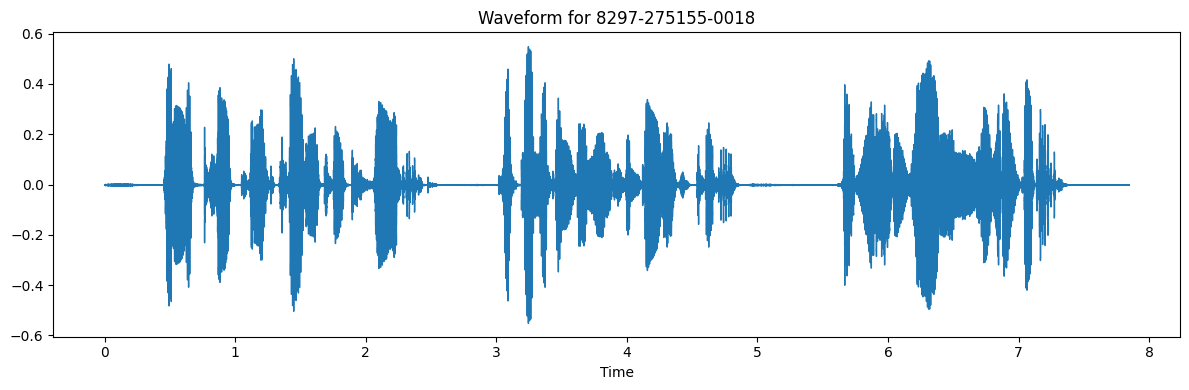


--------------------------------------------------------------------------------

Sample 2:
Speaker ID: 1673
Chapter ID: 143397
Utterance ID: 1673-143397-0012
Text: SIXTY EIGHT BISHOPS TWENTY TWO OF METROPOLITAN RANK DEFENDED HIS CAUSE BY A MODEST AND TEMPERATE PROTEST THEY WERE EXCLUDED FROM THE COUNCILS OF THEIR BRETHREN
Audio Path: data/librispeech/LibriSpeech/dev-clean/1673/143397/1673-143397-0012.flac


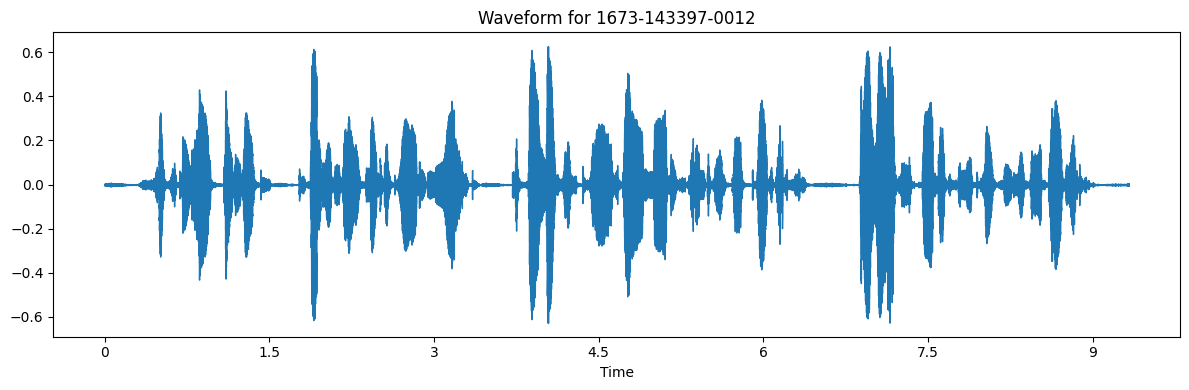


--------------------------------------------------------------------------------

Sample 3:
Speaker ID: 7976
Chapter ID: 105575
Utterance ID: 7976-105575-0021
Text: THE CLOUD OF REBELS WE HAD SEEN DIVIDED ITSELF INTO THREE COLUMNS
Audio Path: data/librispeech/LibriSpeech/dev-clean/7976/105575/7976-105575-0021.flac


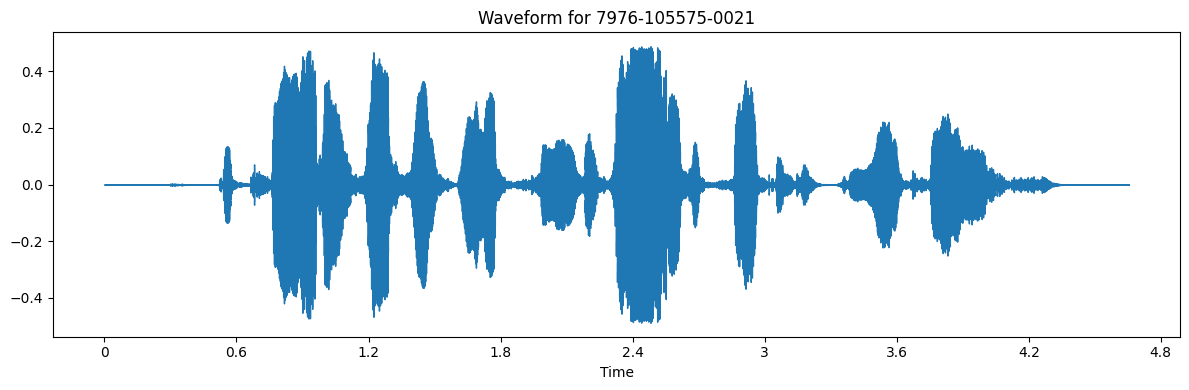


--------------------------------------------------------------------------------



In [9]:
import random
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

# Function to display audio and its transcript
def display_audio_sample(df, num_samples=3):
    # Get random samples
    samples = df.sample(num_samples)
    
    for i, (_, row) in enumerate(samples.iterrows()):
        print(f"Sample {i+1}:")
        print(f"Speaker ID: {row['speaker_id']}")
        print(f"Chapter ID: {row['chapter_id']}")
        print(f"Utterance ID: {row['utterance_id']}")
        print(f"Text: {row['text']}")
        print(f"Audio Path: {row['audio_path']}")
        
        # Load audio
        audio, sr = librosa.load(row['audio_path'], sr=None)
        
        # Display waveform
        plt.figure(figsize=(12, 4))
        librosa.display.waveshow(audio, sr=sr)
        plt.title(f"Waveform for {row['utterance_id']}")
        plt.tight_layout()
        plt.show()
        
        # Play audio
        display(ipd.Audio(audio, rate=sr))
        print("\n" + "-"*80 + "\n")

# Display 3 random samples
display_audio_sample(df, num_samples=3)
